In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from numpy import ndarray
    
import math 
import datetime
import time

2022-02-22 16:07:30.908421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jainy/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.5/lib:/usr/local/cuda-11.5/lib64
2022-02-22 16:07:30.908438: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


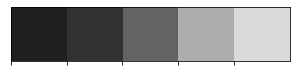

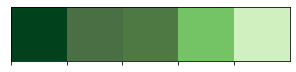

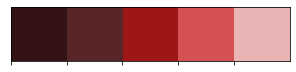

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
x_train = []
y_train = []
image_size = 256
for i in labels:
    folder_path = os.path.join('/media/jainy/project/Depanshu_project/data_/train', i)
    for j in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)
for i in labels:
    folder_path = os.path.join('/media/jainy/project/Depanshu_project/data_/test', i)
    for j in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)


100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 286.22it/s]


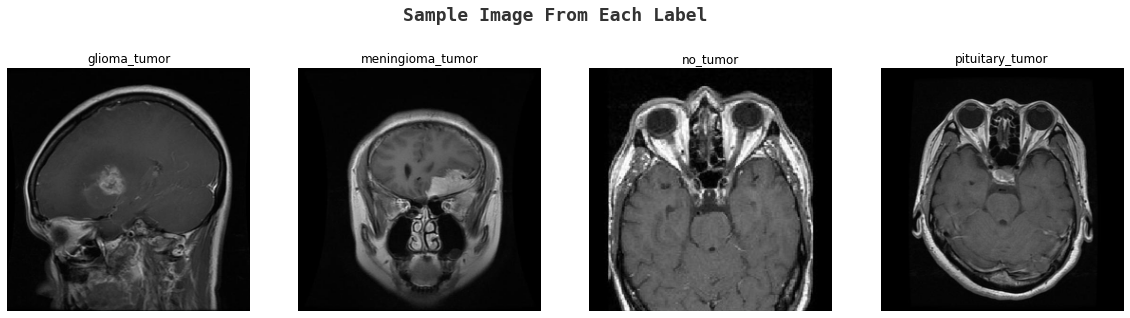

In [5]:


k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=9
    while True :
        if y_train[j]==i:
            ax[k].imshow(x_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1



In [6]:
x_train, y_train = shuffle(x_train,y_train, random_state=101)

In [7]:
x_train.shape

(3264, 256, 256, 3)

In [8]:
y_train.shape

(3264,)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.1,random_state=101)
x_train.shape

(2937, 256, 256, 3)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

2022-02-22 16:07:39.040588: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-22 16:07:39.040606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jainy): /proc/driver/nvidia/version does not exist
2022-02-22 16:07:39.040761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model = inceptionV3.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=inceptionV3.input, outputs = model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("V3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
start = datetime.datetime.now()
history = model.fit(x_train,y_train,validation_split=0.2, epochs =20, verbose=1, batch_size=40,
                   callbacks=[tensorboard,checkpoint,reduce_lr])
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.8140
Epoch 00001: val_accuracy improved from -inf to 0.28231, saving model to V3.h5
59/59 [==============================] - 215s 4s/step - loss: 0.5139 - accuracy: 0.8140 - val_loss: 18.1397 - val_accuracy: 0.2823 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9136
Epoch 00002: val_accuracy improved from 0.28231 to 0.47109, saving model to V3.h5
59/59 [==============================] - 214s 4s/step - loss: 0.2660 - accuracy: 0.9136 - val_loss: 4.2376 - val_accuracy: 0.4711 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9349
Epoch 00003: val_accuracy improved from 0.47109 to 0.72619, saving model to V3.h5
59/59 [==============================] - 214s 4s/step - loss: 0.2006 - accuracy: 0.9349 - val_loss: 1.1702 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/20
59/59 [===========================

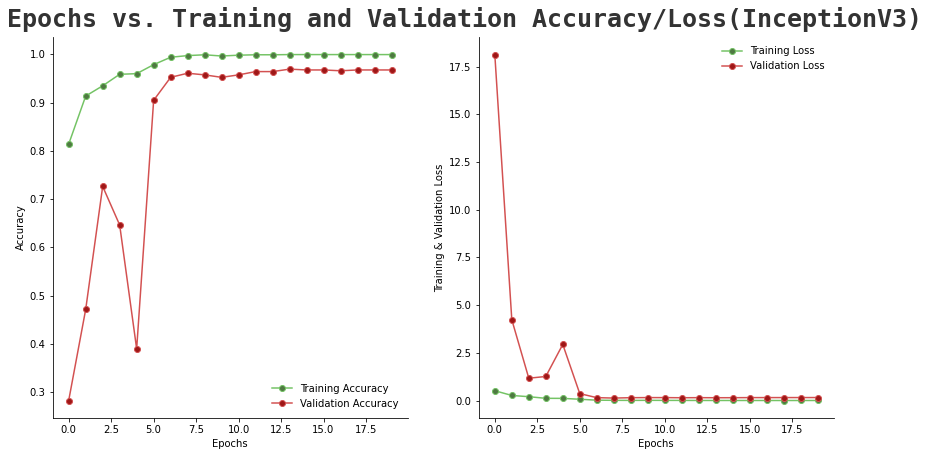

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss(InceptionV3)',size=25,fontweight='bold',
             fontname='monospace',y=0.9,x=0.08,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


fig.savefig('inc.jpg')

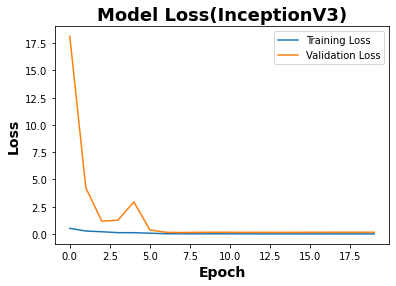

In [20]:
# Plot training & validation loss values
fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss(InceptionV3)', size=18,  y=1,x=0.5,fontweight='bold')
plt.ylabel('Loss',size=14,fontweight='bold')
plt.xlabel('Epoch',size=14,fontweight='bold')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()
fig.savefig("inc_loss.jpg")

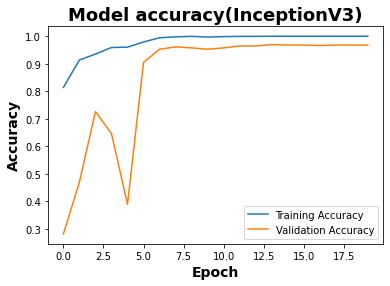

In [21]:
# Plot training & validation accuracy values

fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy(InceptionV3)', size=18,  y=1,x=0.5,fontweight='bold')
plt.ylabel('Accuracy',size=14,fontweight='bold')
plt.xlabel('Epoch',size=14,fontweight='bold')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()
fig.savefig("inc_acc.jpg")


In [22]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [23]:
y = print(classification_report(y_test_new,pred, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

              precision    recall  f1-score   support

      Glioma       0.96      0.92      0.94        93
  Meningioma       0.94      0.97      0.95        95
      Normal       0.96      0.98      0.97        52
   Pituitary       0.99      0.98      0.98        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



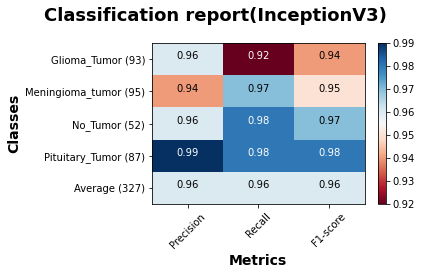

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report(InceptionV3)',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title,size=18,fontweight='bold',y=1.1,x=0.3)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes',size=14,fontweight='bold')
    plt.xlabel('Metrics',size=14,fontweight='bold')
    plt.tight_layout()


def main():

    sampleClassificationReport = """              precision    recall  f1-score   support
True
           Glioma_Tumor       0.96      0.92      0.94        93
           Meningioma_tumor       0.94      0.97      0.95        95
           No_Tumor       0.96      0.98      0.97        52
           Pituitary_Tumor       0.99      0.98      0.98        87


  
Average       0.96      0.96      0.96       327

"""

    plot_classification_report(sampleClassificationReport)
    plt.savefig("inc_CR.jpg")
    plt.show()
    plt.close()


if __name__ == '__main__':
    main()

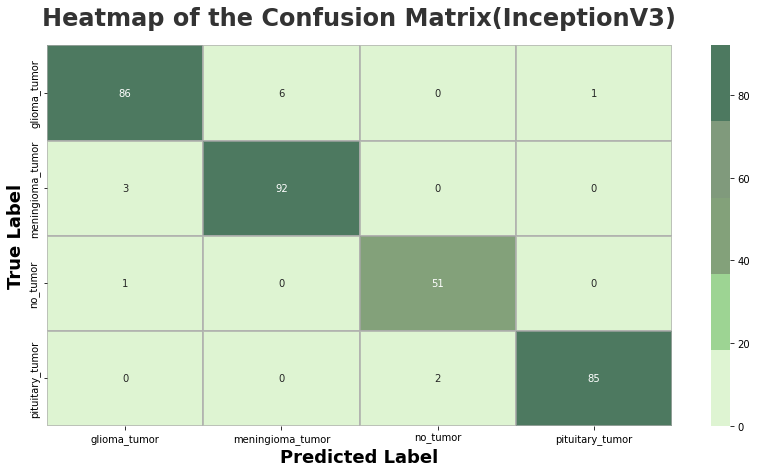

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix(InceptionV3)',size=24,fontweight='bold',
             y=0.92,x=0.12,alpha=0.8)

plt.ylabel('True Label', size=18,fontweight='bold')
plt.xlabel('Predicted Label', size=18,fontweight='bold')
plt.show()
fig.savefig("inc_heatmap.jpg")

In [1]:
import numpy as np
cnf_matrix = np.array([[86,6,0,1],
             [3,92,0,0],
             [1,0,51,0],
             [0,0,2,85]])
print(cnf_matrix)


FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
F1 = (2*PPV*TPR)/(PPV+TPR)

[[86  6  0  1]
 [ 3 92  0  0]
 [ 1  0 51  0]
 [ 0  0  2 85]]


In [2]:
print('Senstivity',TPR)
print('Specificity',TNR)
print('Accuracy',ACC)
print('Precision',PPV)
print('F1',F1)

Senstivity [0.92473118 0.96842105 0.98076923 0.97701149]
Specificity [0.98290598 0.97413793 0.99272727 0.99583333]
Accuracy [0.96636086 0.97247706 0.99082569 0.99082569]
Precision [0.95555556 0.93877551 0.96226415 0.98837209]
F1 [0.93989071 0.95336788 0.97142857 0.98265896]


In [33]:

    img = Image.open('/media/jainy/project/Depanshu_project/data4/test/yes/mg931.jpg')
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(256,256))
    img = img.reshape(1,256,256,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'
    elif p==2:
        p='No Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

The Model predicts that it is a Meningioma Tumor


In [34]:
score = model.evaluate(x_test, y_test, verbose = 0)
score[1]

0.9602446556091309

In [35]:
model.evaluate(x_test, y_test)

11/11 [==============================] - 4s 364ms/step - loss: 0.1634 - accuracy: 0.9602


[0.1634068340063095, 0.9602446556091309]